In [1]:
from __future__ import absolute_import, division, print_function
from google.colab import drive
drive.mount("/content/drive")
#!ls "/content/drive/My Drive"
#!ls "/mount_input"

import pathlib

import pandas as pd
import seaborn as sns

import tensorflow as tf

print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

column_names = ['/render/frame time/rendering/microseconds','ar_GI_diffuse_depth','ar_AA_samples','ar_GI_specular_samples','ar_GI_transmission_samples',
                'ar_GI_diffuse_samples', 'ar_GI_specular_depth', 'ar_bucket_size']
#column_names = ['/render/frame time/rendering/microseconds','ar_AA_samples', 'ar_GI_specular_samples']

raw_dataset = pd.read_csv("/content/drive/My Drive/mount_input/output_data.csv", usecols=column_names, sep=",", skipinitialspace=True)

dataset = raw_dataset.copy()

dataset = dataset.astype("float64")

dataset.tail()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1.13.0-rc1


,ar_GI_specular_samples,/render/frame time/rendering/microseconds,ar_AA_samples,ar_bucket_size,ar_GI_diffuse_depth,ar_GI_diffuse_samples,ar_GI_specular_depth,ar_GI_transmission_samples
983,6.0,2.889439e+08,4.0,482.0,9.0,2.0,7.0,3.0
984,2.0,7.004720e+07,6.0,455.0,8.0,3.0,3.0,0.0
985,2.0,6.282489e+06,3.0,297.0,10.0,8.0,10.0,2.0
986,1.0,1.118134e+08,4.0,378.0,10.0,4.0,2.0,4.0
987,9.0,1.675580e+09,6.0,907.0,9.0,5.0,1.0,1.0


In [2]:

dataset.isnull().sum()


train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)


#sns.pairplot(train_dataset[column_names], diag_kind="kde")

train_stats = train_dataset.describe()
train_stats.pop("/render/frame time/rendering/microseconds")
train_stats = train_stats.transpose()
train_stats

#test_dataset.tail()
train_labels = train_dataset.pop("/render/frame time/rendering/microseconds")
test_labels = test_dataset.pop("/render/frame time/rendering/microseconds")
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

def build_model():
  model =  keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(32, activation=tf.nn.relu),
    layers.Dense(16, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam(0.001)

  model.compile(loss="mse",
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)


model.summary()

example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)



# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop, PrintDot()])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 7,297
Trainable params: 7,297
Non-trainable params: 0
_________________________________________________________________
Instructions for upd

In [3]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
205,1.243722e+18,542489024.0,1.243722e+18,8.695711e+17,518441088.0,8.695712e+17,205
206,1.243695e+18,542206528.0,1.243695e+18,8.691695e+17,517830112.0,8.691695e+17,206
207,1.243653e+18,541683072.0,1.243653e+18,8.689163e+17,517467840.0,8.689163e+17,207
208,1.243679e+18,542118528.0,1.243679e+18,8.695427e+17,518376576.0,8.695427e+17,208
209,1.243657e+18,541846080.0,1.243657e+18,8.689291e+17,517529408.0,8.689291e+17,209


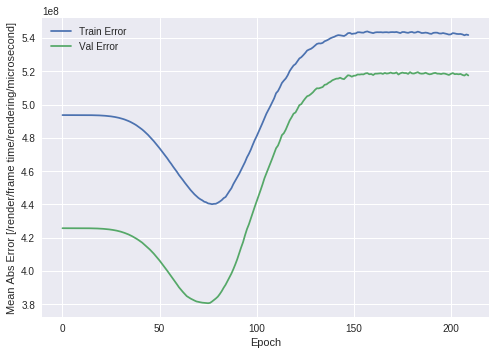

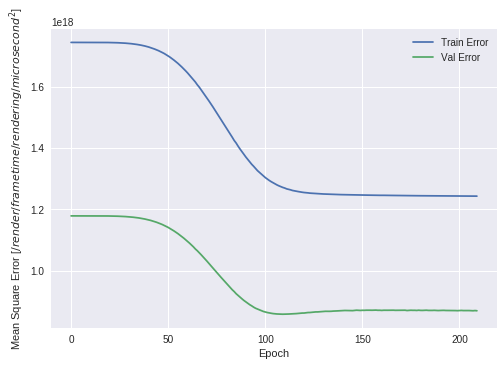

In [4]:
import matplotlib.pyplot as plt

def plot_history(history):
  
  hist = pd.DataFrame(history.history)

  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [/render/frame time/rendering/microsecond]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.legend()
  #plt.ylim([0,5])

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$/render/frame time/rendering/microsecond^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.legend()
  #plt.ylim([0,20])
  
plot_history(history)


In [5]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))


Testing set Mean Abs Error: 722520000.00 MPG


(-427844859.1586246, 8993230852.158625, -98205625.38787712, 9322870085.929373)

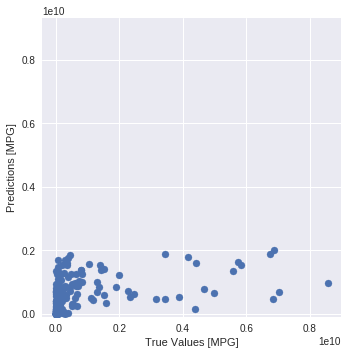

In [6]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
#_ = plt.plot([-100, 100], [-100, 100])


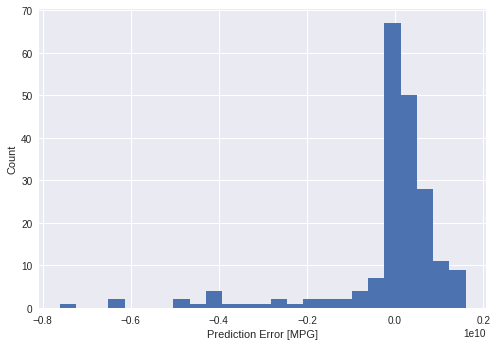

In [7]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")
